In [ ]:
from TradingEnvironment import StockTrading as Env
import DDPG_Algo as ddpg
import pandas as pd

In [ ]:
window=5
frame_bound=(6,1500)

In [51]:
df = pd.read_csv('data/TestData.csv')
df.head()



,Date,open,high,low,close,Adj Close,Volume
0,2013-01-22,6080.15,6101.30,6040.50,6048.50,6048.50,129000
1,2013-01-23,6052.85,6069.80,6021.15,6054.30,6054.30,137000
2,2013-01-24,6046.20,6065.30,6007.85,6019.35,6019.35,185200
3,2013-01-25,6024.50,6080.55,6014.45,6074.65,6074.65,147600
4,2013-01-28,6082.10,6088.40,6061.40,6074.80,6074.80,113100


In [ ]:
my_env = Env(df,5,frame_bound)
obs,_=my_env.reset(10000,0,0)
done=0
total_reward=0
while not done:
    action=my_env.random_action()
    obs,reward,done,info=my_env.step(action)
    total_reward+=reward
    if done:
        print(f"Total Return: {my_env.percentageReturn()} %",f"\t\t\tTotal Reward: {total_reward}")
        my_env.render()

In [ ]:
# Initialize environment and agent
env = Env(df, window, frame_bound)
state_dim = 40  # This is the size of your flattened state
action_dim = 2  # This is the size of your action space

actor = ddpg.Actor(state_dim, action_dim)
critic = ddpg.Critic(state_dim , action_dim)
agent = ddpg.DDPGAgent(env, actor, critic, actor_lr=1e-3, critic_lr=1e-3, gamma=0.99, tau=1e-3, buffer_maxlen=100000)

# Parameters
num_episodes = 100  # How many episodes of interaction to generate
max_steps = 2000  # How many steps of interaction (max) to generate for each episode
batch_size = 50  # How many experiences to use for each update of the networks
max_reward = None
# Start training loop
for i_episode in range(1, num_episodes+1):
    state,_ = env.reset(100000, 0, 0)
    episode_reward = 0

    for t in range(max_steps):
        action = agent.get_action(state)
        action=action.reshape(-1)
        next_state, reward, done, _ = env.step(action)

        agent.replay_buffer.push(state, action, reward, next_state, done)
        if len(agent.replay_buffer) > batch_size:
            agent.update(batch_size)

        state = next_state
        episode_reward += reward

        if done or t == max_steps-1:
            print("Episode %d, reward %f" % (i_episode, episode_reward))
            break
    agent.noise.reset()
    if max_reward is None or episode_reward > max_reward:
        print("Episode: {}, Reward: {}, New record!".format(i_episode, episode_reward))
        max_reward = episode_reward
        agent.save("best_model")
agent.save('end_model')

In [59]:
# df=pd.read_csv('data/TestData.csv')
frame_bound=(6,1500)

env = Env(df, window, frame_bound)

# Create a DDPG agent
agent = ddpg.DDPGAgent(env, actor, critic, actor_lr=1e-4, critic_lr=1e-3, gamma=0.99, tau=1e-2, buffer_maxlen=100000,sigma=0,epsilon=0.1)

# Load the models
agent.load("best_model")  # replace "model" with your actual filename prefix


In [60]:
# Reset the environment to get the initial state
state, info = env.reset(cash=10000000, long=0, short=0)  # replace these parameters with your own initial conditions

done = False
while not done:
    # Reshape state to 2D array
    state = state.reshape(1,-1)

    # Get an action from the DDPG agent (we don't need the epsilon for the exploration when using the model for prediction)
    action = agent.get_action(state)
    action=action.reshape(-1)
    # Take a step in the environment with the action
    next_state, reward, done, info = env.step(action)

    # Set the current state to the next state
    state = next_state
    if done:
        print(f"The percentage return is: {env.percentageReturn()}")



The percentage return is: 82.02


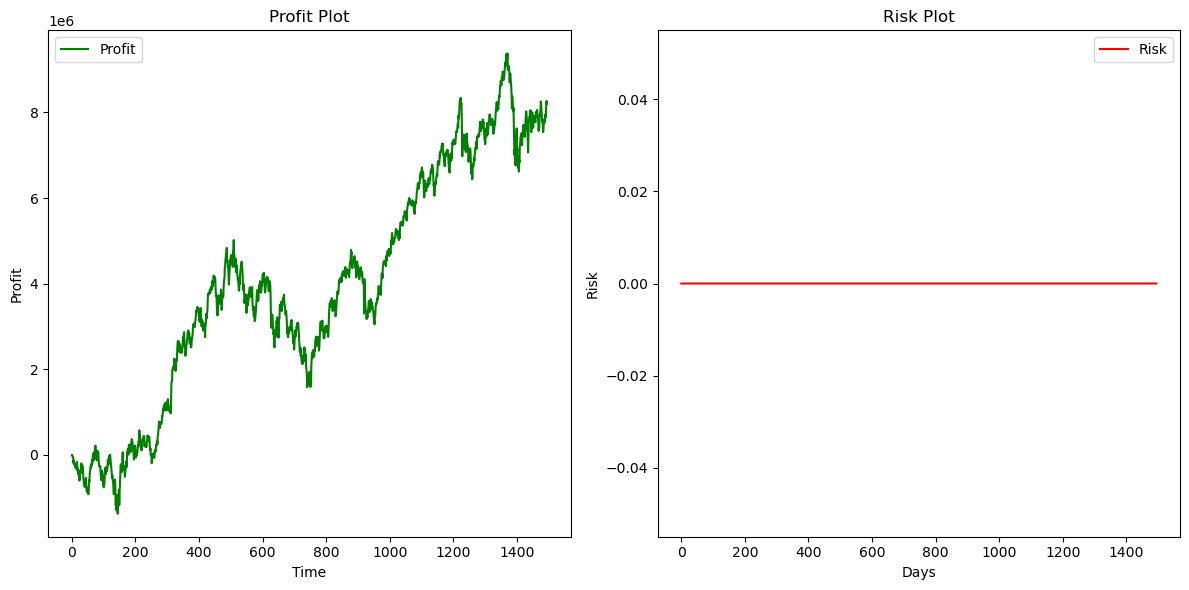

10000000.0

In [61]:
env.render()
env.initial_net_val